In [132]:
from tools.helpers import *
from tools.cluster import relabel, cassign1d
from tools import softmax as sm
from tools import viterbi as vt
from functools import partial, reduce
from itertools import starmap, product
from collections import Counter
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, confusion_matrix, f1_score

pd.plotting.register_matplotlib_converters(explicit=True)
%matplotlib inline

sns.set(style='ticks', color_codes=True)

ALL_DATA_PATH = '../data/all_data.dta'
APPLIANCE = 'TV'

In [2]:
def prepare_data():
    window = id
    temperature = load_data('../data/Temperature_data.csv',
                            post=window(post_temperature))

    occupancy = load_data('../data/Occupancy_data.csv',
                          post=window(post_occupancy),
                          header=None, names=['Time', 'Location'])

    appliance = load_data('../data/Appliance_data.csv',
                          header=None,
                          names=['Time', 'TV', 'Fan', 'Fridge',
                                 'Laptop',
                                 'Heater',
                                 'Oven', 'Unknown', 'Washing',
                                 'Microwave', 'Toaster', 'Sockets',
                                 'Cooker'],
                          skiprows=3,
                          post=window(post_appliance)).loc[:, APPLIANCE]

    total = load_data('../data/Aggregated_data.csv',
                      header=None,
                      names=['Time', 'Main'],
                      skiprows=3,
                      post=window(post_appliance))

    pd.concat([temperature, occupancy, appliance, total], axis=1) \
      .to_pickle(ALL_DATA_PATH)
    
if not os.path.exists(ALL_DATA_PATH):
    prepare_data()
    
data = (pd.read_pickle(ALL_DATA_PATH)
          .assign(State=lambda df: cassign1d(df.TV.values, [0, 40])))

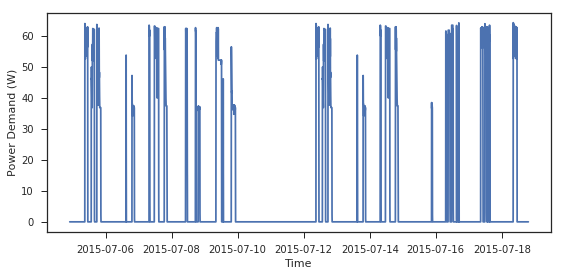

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(data.iloc[:20000, -3])
ax.set_xlabel('Time')
ax.set_ylabel('Power Demand (W)')
fig.tight_layout()
fig.savefig('../report/figures/tv_power.pdf')

In [4]:
hour_encoder = OneHotEncoder(sparse=False).fit(np.arange(24).reshape(-1, 1))
day_encoder = OneHotEncoder(sparse=False).fit(np.arange(7).reshape(-1, 1))

def split_data(data):
    _data = pd.concat([data, data.State.shift(-1).rename('NState')], axis=1).dropna()
    state_pars = (_data.groupby('State')['TV']
                       .agg(['mean', 'std'])
                       .rename({'mean': 'loc', 'std': 'scale'}, axis=1)
                       .to_dict('index'))
    xmat = np.hstack([_data.iloc[:, :-4].values,
                      hour_encoder.transform(_data.index.hour.values.reshape(-1, 1)),
                      day_encoder.transform(_data.index.dayofweek.values.reshape(-1, 1))])
    svec = _data.loc[:, 'State'].values
    nsvec = _data.loc[:, 'NState'].values
    pfvec = _data.loc[:, 'TV'].values
    pmain = _data.loc[:, 'Main'].values
    ovec = [*zip(pmain, [None, *np.diff(pmain)])]
    
    return {'state_pars': state_pars,
            'features': xmat,
            'states': svec,
            'nstates': nsvec,
            'powers': pfvec,
            'obs': ovec}

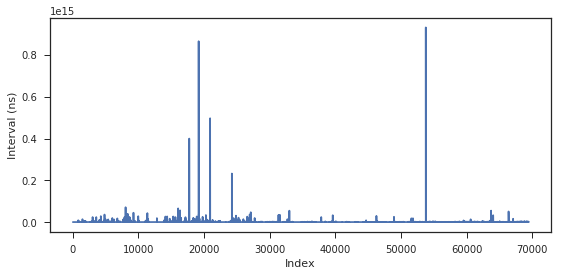

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
pd.Series(data.dropna().index).diff().plot(ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Interval (ns)')
fig.tight_layout()
fig.savefig('../report/figures/gaps.pdf')

In [6]:
hmm_index = pd.Int64Index(range(42000, 47000))
softmax_index = pd.Int64Index(np.arange(len(data))).difference(hmm_index)

In [7]:
pd.Series(data.iloc[hmm_index, :].dropna().index).diff().describe()

count                      1696
mean     0 days 00:02:39.091981
std      0 days 00:26:00.139582
min             0 days 00:01:00
25%             0 days 00:01:00
50%             0 days 00:01:00
75%             0 days 00:01:00
max             0 days 12:26:00
Name: Time, dtype: object

In [8]:
hmm_data = data.iloc[hmm_index, :].fillna(method='ffill')
pd.Series(hmm_data.dropna().index).diff().describe()

count               4515
mean     0 days 00:01:00
std      0 days 00:00:00
min      0 days 00:01:00
25%      0 days 00:01:00
50%      0 days 00:01:00
75%      0 days 00:01:00
max      0 days 00:01:00
Name: Time, dtype: object

In [9]:
softmax_data = data.iloc[softmax_index, :].reindex(data.index)
fsoftmax_data = split_data(softmax_data)

In [73]:
def comp_models(model_pars, labels, data):
    y_encoder = OneHotEncoder(sparse=False).fit(np.array([[0], [1]]))  # actually no need to encode y, but...
    splitter = KFold(5)
    factor = 1 / 5

    def calc_metrics(model, xmat, this_y, next_y):
        p_this_y = model[0](xmat).reshape(-1, 2)
        p_next_y = model[1](np.hstack([xmat, y_encoder.transform(this_y.reshape(-1, 1))]))
        return {
            'init_proba_loss': log_loss(this_y, p_this_y),
            'trans_proba_loss': log_loss(next_y, p_next_y),
            'init_proba_auroc': roc_auc_score(this_y, p_this_y[:, 1], 'micro'),
            'trans_proba_auroc': roc_auc_score(next_y, p_next_y[:, 1], 'micro'),
            'init_proba_aupr': average_precision_score(this_y, p_this_y[:, 1], 'micro'),
            'trans_proba_aupr': average_precision_score(next_y, p_next_y[:, 1], 'micro')
        }
    
    def gen_models(train_idx):
        for par in model_pars:
            yield sm.softmax(data['features'][train_idx, :],
                             data['states'][train_idx],
                             data['nstates'][train_idx], **par)

    def helper(train_idx, val_idx):
        yield from map(lambda x: calc_metrics(x, data['features'][val_idx, :],
                                              data['states'][val_idx],
                                              data['nstates'][val_idx]),
                       gen_models(train_idx))
        ## baseline
        this_y = data['states']
        next_y = data['nstates']
        p_this_y = np.array([np.unique(this_y[train_idx], return_counts=True)[1] / len(train_idx)
                             for _ in range(len(val_idx))])
        trans_proba = {k: v / len(train_idx) for k, v in Counter(zip(this_y[train_idx],
                                                                     next_y[train_idx])).items()}
        p_next_y = np.array([trans_proba[(x, 1)] for x in this_y[val_idx]])
        yield {
            'init_proba_loss': log_loss(this_y[val_idx], p_this_y),
            'trans_proba_loss': log_loss(next_y[val_idx], p_next_y),
            'init_proba_auroc': roc_auc_score(this_y[val_idx], p_this_y[:, -1], 'micro'),
            'trans_proba_auroc': roc_auc_score(next_y[val_idx], p_next_y, 'micro'),
            'init_proba_aupr': average_precision_score(this_y[val_idx], p_this_y[:, -1], 'micro'),
            'trans_proba_aupr': average_precision_score(next_y[val_idx], p_next_y, 'micro')
        }

    results = starmap(helper, splitter.split(data['features']))

    def merge(loms1, loms2):
        for m1, m2 in zip(loms1, loms2):
            yield {k: m1[k] + m2[k] * factor for k in m1}
    
    return dict(zip(labels, reduce(merge, results, [{
            'init_proba_loss': 0,
            'trans_proba_loss': 0,
            'init_proba_auroc': 0,
            'trans_proba_auroc': 0,
            'init_proba_aupr': 0,
            'trans_proba_aupr': 0
        } for _ in range(len(labels))])))

In [74]:
pars = [{'C': 0.1, 'penalty': 'l2'},
        {'C': 0.5, 'penalty': 'l2'},
        {'C': 1.0, 'penalty': 'l2'},
        {'C': 5.0, 'penalty': 'l2'},
        {'C': 0.1, 'penalty': 'l1'},
        {'C': 0.5, 'penalty': 'l1'},
        {'C': 1.0, 'penalty': 'l1'},
        {'C': 5.0, 'penalty': 'l1'}]

labels = [*['Softmax, C = {}, {}'.format(p['C'], p['penalty']) for p in pars], 'Baseline']

metrics = comp_models(pars, labels, fsoftmax_data)

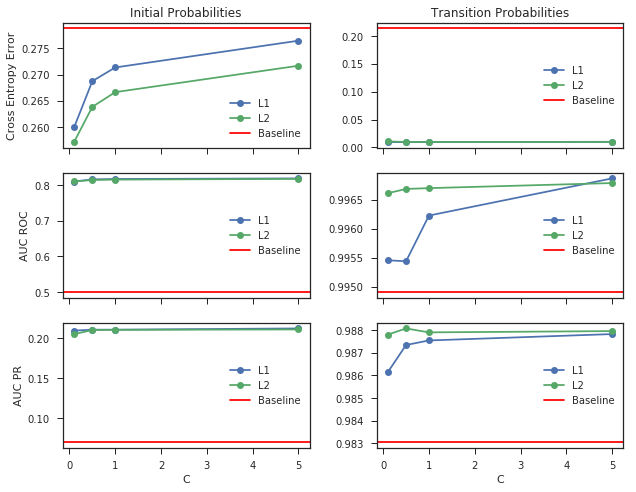

In [80]:
## ...that is very time-consuming, so...
c_pat = re.compile(r'= ([0-9.]*)')
l1 = pd.DataFrame([dict(**metrics[k], C=float(c_pat.search(k).group(1)))
                   for k in metrics if 'l1' in k])
l2 = pd.DataFrame([dict(**metrics[k], C=float(c_pat.search(k).group(1)))
                   for k in metrics if 'l2' in k])

fig, axs = plt.subplots(3, 2, figsize=(9, 7), sharex=True)
cur = axs[0][0]
cur.set_title('Initial Probabilities')
cur.plot(l1['C'], l1['init_proba_loss'], 'bo-', label='L1')
cur.plot(l2['C'], l2['init_proba_loss'], 'go-', label='L2')
cur.axhline(metrics['Baseline']['init_proba_loss'], c='red', label='Baseline')
cur.set_ylabel('Cross Entropy Error')
cur.legend()
cur = axs[1][0]
cur.plot(l1['C'], l1['init_proba_auroc'], 'bo-', label='L1')
cur.plot(l2['C'], l2['init_proba_auroc'], 'go-', label='L2')
cur.axhline(metrics['Baseline']['init_proba_auroc'], c='red', label='Baseline')
cur.set_ylabel('AUC ROC')
cur.legend()
cur = axs[2][0]
cur.plot(l1['C'], l1['init_proba_aupr'], 'bo-', label='L1')
cur.plot(l2['C'], l2['init_proba_aupr'], 'go-', label='L2')
cur.axhline(metrics['Baseline']['init_proba_aupr'], c='red', label='Baseline')
cur.set_xlabel('C')
cur.set_ylabel('AUC PR')
cur.legend()
cur = axs[0][1]
cur.set_title('Transition Probabilities')
cur.plot(l1['C'], l1['trans_proba_loss'], 'bo-', label='L1')
cur.plot(l2['C'], l2['trans_proba_loss'], 'go-', label='L2')
cur.axhline(metrics['Baseline']['trans_proba_loss'], c='red', label='Baseline')
cur.legend()
cur = axs[1][1]
cur.plot(l1['C'], l1['trans_proba_auroc'], 'bo-', label='L1')
cur.plot(l2['C'], l2['trans_proba_auroc'], 'go-', label='L2')
cur.axhline(metrics['Baseline']['trans_proba_auroc'], c='red', label='Baseline')
cur.legend()
cur = axs[2][1]
cur.plot(l1['C'], l1['trans_proba_aupr'], 'bo-', label='L1')
cur.plot(l2['C'], l2['trans_proba_aupr'], 'go-', label='L2')
cur.axhline(metrics['Baseline']['trans_proba_aupr'], c='red', label='Baseline')
cur.set_xlabel('C')
cur.legend()
fig.tight_layout()
fig.savefig('../report/figures/softmax-metrics.pdf')

In [81]:
init_proba, trans_proba = sm.softmax(fsoftmax_data['features'],
                                     fsoftmax_data['states'],
                                     fsoftmax_data['nstates'])

In [83]:
emx, emy = vt.get_npem_fns(fsoftmax_data['state_pars'])

In [84]:
fhmm_data = split_data(hmm_data)
predicted_states = [*vt.viterbi(fhmm_data['obs'], fhmm_data['features'], trans_proba,
                                init_proba(fhmm_data['features'][0, :]), emx, emy, 0.033)]

In [85]:
smoothed_states = moving_mode(predicted_states, 3)

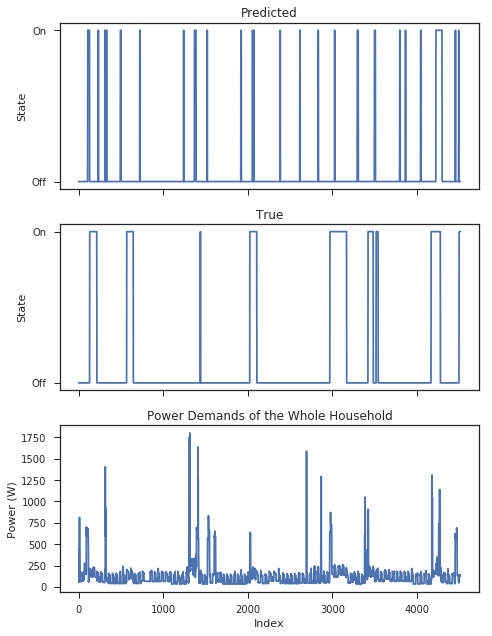

In [104]:
labeller = FuncFormatter(lambda y, _: {0: 'Off', 1: 'On'}[int(y)])

fig, axs = plt.subplots(3, 1, figsize=(7, 9), sharex=True)
axs[0].plot(smoothed_states)
axs[0].yaxis.set_major_formatter(labeller)
axs[0].set_yticks([0, 1])
axs[0].set_ylabel('State')
axs[0].set_title('Predicted')
axs[1].plot(fhmm_data['states'])
axs[1].yaxis.set_major_formatter(labeller)
axs[1].set_yticks([0, 1])
axs[1].set_ylabel('State')
axs[1].set_title('True')
axs[2].plot([*map(lambda x: x[0], fhmm_data['obs'])])
axs[2].set_ylabel('Power (W)')
axs[2].set_title('Power Demands of the Whole Household')
axs[2].set_xlabel('Index')
fig.tight_layout()
fig.savefig('../report/figures/hmm-results.pdf')

In [126]:
cm = confusion_matrix(fhmm_data['states'], smoothed_states)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

In [133]:
f1_score(fhmm_data['states'], smoothed_states)

0.14071510957324107

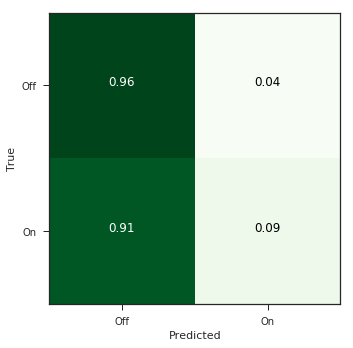

In [131]:
fig, ax = plt.subplots(figsize=(5, 5))
img = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.xaxis.set_major_formatter(labeller)
ax.yaxis.set_major_formatter(labeller)
thresh = cm.max() / 2.
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], '.2f'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
fig.tight_layout()
fig.savefig('../report/figures/cm.pdf')